# Анализ рынка заведений общественного питания Москвы

<a href="https://yadi.sk/i/s5kgM1zgXHD2ZA">
Ссылка на презентацию в PDF
</a>

## Содержание

1. [Задание](#task)
1. [Описание данных](#data_description)
1. [Импорт библиотек и общая предустановка](#import)
1. [Импорт и общее изучение первичных данных](#first_look)
    1. [Данные Яндекса](#yabdex_data)
    1. [Данные Правительства Москвы](#mos_data)
1. [Подготовка данных](#etl)
1. [Анализ данных](#analysis)
1. [Вывод](#conclusion)
1. [Презентация](#presentation)

## Задание
<a id = "task"></a>

Компания решила открыть небольшое кафе в Москве. Проект дорогой — гостей должны обслуживать роботы. Инвесторы просят подготовить исследование рынка заведений общественного питания в Москве в виде презентации.

## Описание данных
<a id = "data_description"></a>

Таблица __rest_data__:  
- id — идентификатор объекта общественного питания
- object_name — название объекта общественного питания
- chain — сетевой ресторан
- object_type — тип объекта общественного питания
- address — адрес
- number — количество посадочных мест

## Импорт библиотек и глобальная предустановка
<a id = "import"></a>

In [60]:
import pandas as pd
import numpy as np

import io
from io import BytesIO
import requests
import re
from bs4 import BeautifulSoup

from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import plotly.express as px
import plotly.graph_objects as go

import warnings

import re

%matplotlib inline

# отключение предупреждений Anaconda
warnings.simplefilter('ignore')

from pylab import rcParams

# размер графиков по умолчанию
rcParams['figure.figsize'] = 12, 12

title_font = {
    'size':'20', 
    'color':'black', 
    'weight':'bold',
    'verticalalignment':'bottom'
}

axis_font = {
    'size':'18', 
    'weight':'bold'
}

# отображение одного знака после запятой
pd.options.display.float_format = '{:,.1f}'.format

## Импорт и общее изучение первичных данных
<a id = "first_look"></a>

### Данные Яндекса
<a id = "yabdex_data"></a>

In [61]:
rest_data = pd.read_csv('rest_data.csv')

In [62]:
rest_data.head(10)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


In [63]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [64]:
rest_data[rest_data['id'].duplicated()]

,id,object_name,chain,object_type,address,number


В датафрейме __rest_data__ данных Яндекса:
- пропусков нет,
- дубликатов нет,
- перевод в другой тип данных не требуется. 

### Данные Правительства Москвы
<a id = "mos_data"></a>

Для сопоставления улицы и района Москвы потребуются открытые данные Правительства Москвы.

#### Общемосковский классификатор улиц Москвы

Общемосковский классификатор улиц Москвы (ОМК 001-2013) Раздел 1 загружен из <a href="https://data.mos.ru/classifier/7710168515-obshchemoskovskiy-klassifikator-ulits-moskvy-omk-001-2013-razdel-1/passport?versionNumber=1&releaseNumber=37">Портала открытых данных Правительства Москвы</a>. Версия 1.36 от 05.07.2020

In [65]:
# парсинг описания структуры набора данных Общемосковского классификатора улиц Москвы
oku_request = requests.get('https://data.mos.ru/apiproxy/opendata/7710168515-obshchemoskovskiy-klassifikator-ulits-moskvy-omk-001-2013-razdel-1/structure-20151201(vs1).json')

oku_response_parsed = json.loads(oku_request.text)

oku_response_parsed['Columns']#.keys()

[{'Name': 'UM_NAMEF',
  'Caption': 'Полное наименование',
  'Visible': True,
  'Type': 'STRING',
  'SubColumns': None},
 {'Name': 'UM_CODE',
  'Caption': 'Код',
  'Visible': False,
  'Type': 'STRING',
  'SubColumns': None},
 {'Name': 'UM_NAMES',
  'Caption': 'Сокращённое наименование',
  'Visible': True,
  'Type': 'STRING',
  'SubColumns': None},
 {'Name': 'UM_TRANS',
  'Caption': 'Транслитерация',
  'Visible': False,
  'Type': 'STRING',
  'SubColumns': None},
 {'Name': 'UM_TYPE',
  'Caption': 'Код вида',
  'Visible': False,
  'Type': 'STRING',
  'SubColumns': None},
 {'Name': 'UM_TM',
  'Caption': 'Код ОМК ТМ',
  'Visible': False,
  'Type': 'STRING',
  'SubColumns': None},
 {'Name': 'UM_TE',
  'Caption': 'Код ОМК ТЕ',
  'Visible': True,
  'Type': 'STRING',
  'SubColumns': None},
 {'Name': 'UM_KLADR',
  'Caption': 'Код КЛАДР',
  'Visible': True,
  'Type': 'STRING',
  'SubColumns': None},
 {'Name': 'global_id',
  'Caption': 'global_id',
  'Visible': False,
  'Type': 'NUMBER',
  'SubColu

In [66]:
try:
    okum_spreadsheet_id = '1Z00km3ZR5LGpJL72uV6gHEXbTc055gIOiy59XOzJNek'
    okum_url = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(okum_spreadsheet_id)
    r = requests.get(okum_url)
    okum = pd.read_csv(BytesIO(r.content))

except:
    okum = pd.read_excel('okum.xlsx')

okum.sample(10)

,UM_CODE,UM_NAMEF,global_id,UM_NAMES,UM_TRANS,UM_TYPE,UM_TM,UM_TE,UM_KLADR
3937,63752,106-й километр Московской Кольцевой Автодороги,58485063,106-й км МКАД,Sto Shestoj kilometr Moskovskoj Kol`czevoj Avt...,45,NaN,0405,77000000000735800
3993,93018,Иваньковский мост,58485121,Иваньковский мост,Ivan`kovskij most,11,NaN,0903,NaN
1656,24725,улица Анны Северьяновой,58482737,ул. Анны Северьяновой,ulicza Anny' Sever`yanovoj,1,NaN,0106,77000000000075300
3014,44620,Видная улица,58484139,Видная ул.,Vidnaya ulicza,1,735620,1206,77013000013000500
2629,42690,Раздольная улица,58483746,Раздольная ул.,Razdol`naya ulicza,1,734490,1102,77003000005000600
5050,49075,Старомарковский проезд,281605576,Старомарковский пр-д,Staromarkovskij proezd,3,NaN,0315,77000000000785700
1591,24274,4-я улица Новые Сады,58482672,4-я ул. Новые Сады,Chetvyortaya ulicza Novy'e Sady',1,NaN,0811,77000000000208000
4415,3620,Внутренний проезд,58485550,Внутренний пр.,Vnutrennij proezd,3,NaN,0703,77000000000098600
2600,42545,Тюменский проезд,58483716,Тюменский пр.,Tyumenskij proezd,3,734400,1102,77003000004001700
4785,7050,Еготьевский тупик,58485940,Еготьевский туп.,Egot`evskij tupik,7,NaN,0616,77000000000358600


In [67]:
okum.columns = ['um_code', 'name_full', 'global_id', 'name_short', 'trans', 'type',
       'tm', 'okt_te', 'kladr']

In [68]:
okum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5233 entries, 0 to 5232
Data columns (total 9 columns):
um_code       5233 non-null int64
name_full     5233 non-null object
global_id     5233 non-null int64
name_short    5233 non-null object
trans         5233 non-null object
type          5233 non-null int64
tm            1305 non-null object
okt_te        5233 non-null object
kladr         5075 non-null object
dtypes: int64(3), object(6)
memory usage: 368.1+ KB


- Пропуски в столбцах tm и kladr не участвуют в анализе. Обработка не требуется.
- В ячейках столбца okt_te могут находится перечни значений. Необходимо учесть при парсинге.

#### Общемосковский классификатор территориальных единиц Москвы

Общемосковский классификатор территориальных единиц Москвы (ОМК 002-2013) Раздел 1 загружен из <a href="https://data.mos.ru/classifier/7710168515-obshchemoskovskiy-klassifikator-territorialnyh-edinits-moskvy-omk-002-2013-razdel-1/passport?versionNumber=1&releaseNumber=5">Портала открытых данных Правительства Москвы</a>. Версия 1.5 от 18.12.2018

In [69]:
# парсинг описания структуры набора данных ОКТ ТЕ
okt_te_passport_request = requests.get('https://data.mos.ru/apiproxy/opendata/7710168515-obshchemoskovskiy-klassifikator-territorialnyh-edinits-moskvy-omk-002-2013-razdel-1/structure-20160730(vs1).json')

okt_te_passport_response_parsed = json.loads(okt_te_passport_request.text)

okt_te_passport_response_parsed#.keys()

{'Id': 2039,
 'IdentificationNumber': '7710168515-omkteomk0022013razdel1',
 'CategoryId': 21,
 'CategoryCaption': 'Справочная информация',
 'DepartmentId': 181,
 'DepartmentCaption': 'Департамент экономической политики и развития города Москвы',
 'Caption': 'Общемосковский классификатор территориальных единиц Москвы (ОМК 002-2013) Раздел 1',
 'Description': 'Объектами классификации в ОМК ТЕ являются территориальные единицы города Москвы – районы, поселения и административные округа, имеющие наименования и границы, закрепленные правовыми актами города Москвы.',
 'FullDescription': None,
 'Keywords': 'ОМК ТЕ, ОМК ТЕ (ОМК 002-2013), ОМК ТЕ (ОМК 002-2013) Раздел 1, Общемосковский классификатор территориальных единиц Москвы (ОМК 002-2013), Общемосковский классификатор территориальных единиц Москвы (ОМК 002-2013) Раздел 1, Общемосковский классификатор территориальных единиц Москвы',
 'ContainsGeodata': False,
 'VersionNumber': '1.5',
 'VersionDate': '18.12.2018',
 'ItemsCount': 158,
 'Column

In [70]:
try:
    okt_te_spreadsheet_id = '1wy-K8gOwFvWDVNr3jmd8P5oMn-ppD4nFL4JCmoBe4NM'
    okt_te_url = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(okt_te_spreadsheet_id)
    r = requests.get(okt_te_url)
    okt_te = pd.read_csv(BytesIO(r.content))
    
except:
    okt_te = pd.read_excel('okt_te.xlsx')
    
okt_te

,Kod,Name,global_id,Latin_name,Type,Kod_okato
0,100,Центральный административный округ,58703558,Czentral`ny'j administrativny'j okrug,2,45286000
1,101,район Арбат,58703559,rajon Arbat,3,45286552
2,102,Басманный район,58703560,Basmanny'j rajon,3,45286555
3,103,район Замоскворечье,58703561,rajon Zamoskvorech`e,3,45286560
4,104,Красносельский район,58703562,Krasnosel`skij rajon,3,45286565
...,...,...,...,...,...,...
153,1206,поселение Новофедоровское,58703712,poselenie Novofedorovskoe,4,45298567
154,1207,поселение Первомайское,58703713,poselenie Pervomajskoe,4,45298572
155,1208,поселение Роговское,58703714,poselenie Rogovskoe,4,45298575
156,1209,поселение Троицк,58703715,poselenie Troiczk,4,45298578


In [71]:
okt_te.columns = ['okt_te', 'name', 'global_id', 'latin_name', 'type', 'okato']

In [72]:
okt_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 6 columns):
okt_te        158 non-null int64
name          158 non-null object
global_id     158 non-null int64
latin_name    158 non-null object
type          158 non-null int64
okato         158 non-null int64
dtypes: int64(4), object(2)
memory usage: 7.5+ KB


Обработка датафрейма не требуется.

#### Общемосковский классификатор территорий Москвы

Общемосковский классификатор территорий в Москве (ОМК 005-2013) Раздел 1 загружен из <a href="https://data.mos.ru/classifier/7710168515-obshchemoskovskiy-klassifikator-territoriy-v-moskve-omk-005-2013-razdel-1/data/table?versionNumber=1&releaseNumber=5">Портала открытых данных Правительства Москвы</a>. Версия 1.5 от 14.05.2019

In [73]:
# парсинг описания структуры набора данных ОКТ Т
okt_t_passport_request = requests.get('https://data.mos.ru/apiproxy/opendata/7710168515-obshchemoskovskiy-klassifikator-territoriy-v-moskve-omk-005-2013-razdel-1/structure-20151201(vs1).json')

okt_t_passport_response_parsed = json.loads(okt_t_passport_request.text)

okt_t_passport_response_parsed#.keys()

{'Id': 2041,
 'IdentificationNumber': '7710168515-omktmomk0052013razdel1',
 'CategoryId': 21,
 'CategoryCaption': 'Справочная информация',
 'DepartmentId': 181,
 'DepartmentCaption': 'Департамент экономической политики и развития города Москвы',
 'Caption': 'Общемосковский классификатор территорий в Москве (ОМК 005-2013) Раздел 1',
 'Description': 'Объектами классификации в ОМК ТМ являются внутригородские территориальные (площадные) географические объекты, имеющие наименования и используемые в установленном порядке для адресации зданий и сооружений города Москвы.',
 'FullDescription': None,
 'Keywords': 'ОМК ТМ',
 'ContainsGeodata': False,
 'VersionNumber': '1.5',
 'VersionDate': '14.05.2019',
 'ItemsCount': 320,
 'Columns': [{'Name': 'TM_CODE',
   'Caption': 'Код',
   'Visible': True,
   'Type': 'STRING',
   'SubColumns': None},
  {'Name': 'TM_NAMEF',
   'Caption': 'Полное наименование',
   'Visible': True,
   'Type': 'STRING',
   'SubColumns': None},
  {'Name': 'TM_NAMES',
   'Captio

In [74]:
try:
    okt_t_spreadsheet_id = '1UXGNs1ESrYWtvaQ8ohFt_wrAZwN0Nie7Uun4DnNIG5A'
    okt_t_url = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(okt_t_spreadsheet_id)
    r = requests.get(okt_t_url)
    okt_t = pd.read_csv(BytesIO(r.content))

except:
    okt_t = pd.read_excel('okt_t.xlsx')
    
okt_t

,TM_CODE,TM_NAMEF,global_id,TM_NAMES,TM_TRANS,TM_TYPE,TM_TE,TM_KLADR,TM_STAT
0,700230,посёлок Акулово,58476453,пос. Акулово,posyolok Akulovo,215,0414,7700000004500,
1,703580,посёлок Внуково,58476454,пос. Внуково,posyolok Vnukovo,215,0813,7700000000200,
2,704170,посёлок Восточный,58476455,пос. Восточный,posyolok Vostochny'j,215,0414,7700000000300,
3,704785,посёлок Главмосстроя,58476456,пос. Главмосстроя,posyolok Glavmosstroya,215,0906,7700000000400,
4,707615,посёлок Загорье,58476457,пос. Загорье,posyolok Zagor`e,215,0606,7700000000600,
...,...,...,...,...,...,...,...,...,...
315,736980,село Красная Пахра,58476776,с. Красная Пахра,selo Krasnaya Paxra,229,1204,7700800000100,01
316,736990,деревня Бараново,58476777,дер. Бараново,derevnya Baranovo,220,1207,7701400000500,01
317,737000,город Троицк,58476778,г. Троицк,gorod Troiczk,222,1209,7700000500000,01
318,737010,город Щербинка,58476779,г. Щербинка,gorod Shherbinka,222,1111,7700000300000,01


In [75]:
okt_t.columns = ['code', 'name_full', 'global_id', 'name_short', 'latin_name', 'type', \
'omk_te', 'kladr', 'stat']

In [76]:
okt_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 9 columns):
code          320 non-null int64
name_full     320 non-null object
global_id     320 non-null int64
name_short    320 non-null object
latin_name    320 non-null object
type          320 non-null int64
omk_te        320 non-null object
kladr         318 non-null object
stat          320 non-null object
dtypes: int64(3), object(6)
memory usage: 22.6+ KB


In [77]:
okt_t[okt_t.kladr.isna()]

,code,name_full,global_id,name_short,latin_name,type,omk_te,kladr,stat
7,708695,посёлок Ильинский,58476460,пос. Ильинский,posyolok Il`inskij,215,0315,NaN,
19,731845,деревня Щербинка,58476473,дер. Щербинка,derevnya Shherbinka,220,0711,NaN,


Пропуски в столбце КЛАДР не критичны для анализа. Обработка не требуется.

### Промежуточный вывод.

Данные для анализа загружены. Необходимо их обработать.

## Подготовка данных
<a id = "etl"></a>

### Обработка адреса и выделение улицы

Для анализа необходимо выделить улицы, на которых расположены объекты общественного питания:
1. Создание функции выделения населенного пункта.   
    - Это необходимо что бы исключить из анализа улицы на территориях Новой Москвы.   
    - Алгоритм функции:
        - Разбить адрес по запятым.
        - Поверить вхождение в непосредственно Москву или в Общемосковский классификатор территорий Москвы (ОКТ Т).
1. Создание функции выделения улицы и ее кода ОКТ ТЕ.
    - Код необходим для определения района Москвы.
    - Алгоритм функции:
        - Разбить адрес по запятым.
        - Проверить вхождение в Общемосковский классификатор улиц Москвы.
1. Создание функции выделения района Москвы.
    - Алгоритм функции:
        - Принять данные об улице и ее код ОКТ ТЕ.
        - Если код ОКТ ТЕ однозначный, то найти в датафрейме okt_te соответствующий район.
        - Если на улицу несколько кодов ОКТ ТЕ, то обратиться к сайту http://mosopen.ru спарсить первый район улицы
1. Создание главной функции, которая вызывает предыдущие три функции

#### Основной парсинг

##### Подготовка функций парсинга

In [78]:
# функция парсинга населенного пункта из адреса
def get_locality(address):
    
    locality = []
    
    # разделение и перебор адреса
    address_splitted = address.split(",")
    
    # перебор адресов Новой Москвы
    for string in address_splitted:
        
        # удаление пробелов с обоих концов
        string_clean = string.strip()
        
        # проверка вхождения в территории Новой Москвы
        try:
            locality = okt_t[okt_t['name_full'].str.contains(string_clean)]['name_full'].values[0]
            break
        except:
            continue
    
    # если территории не найдены, то проверить Москва ли это
    if len(locality) == 0:
        for string in address_splitted:
            # удаление пробелов с обоих концов
            string_clean = string.strip()
            # проверка вхождения в Москву
            try:
                if re.search('Москва', string_clean):
                    locality = 'Москва'
            except:
                continue
    
    # если вообще ничего не найдено
    if len(locality) == 0:
        locality = 'Город не определен'
    
    try:
        return locality
    except:
        return 'ошибка'
    

# проверка работы функции

#test_address = rest_data.iloc[859]['address']
test_address = rest_data['address'].sample(1).values[0]
print(test_address)
print(get_locality(test_address))

город Москва, Красноказарменная улица, дом 14, строение 3
Москва


In [79]:
# функция парсинга населенного пункта и улицы из адреса
def get_street(address):
    
    # разделение и перебор адреса
    address_splitted = address.split(",")
    for string in address_splitted:
        
        # удаление пробелов с обоих концов
        string_clean = string.strip()
        
        # проверка вхождения адреса в датафрейм okum
        try:
            okt_te = okum[okum['name_full'].str.contains(string_clean)]['okt_te'].values[0]
            street = okum[okum['name_full'].str.contains(string_clean)]['name_full'].values[0]
            break
        except:
            street = 'Улица не определена'
            continue
               
    try:
        return street, okt_te
    except:
        return 'ошибка', 'ошибка'
    

# проверка работы функции

#test_address = rest_data.iloc[859]['address']
test_address = rest_data['address'].sample().values[0]
print(test_address)
print(get_street(test_address))

город Москва, улица Адмирала Руднева, дом 20
('улица Адмирала Руднева', '0711')


In [105]:
# функция парсинга населенного пункта и улицы из адреса
def get_district(street_okt_te_temp):
    
    # разбивает входные данные на улицу и ОКТ ТЕ
    street_temp = street_okt_te_temp[0]
    okt_te_temp = street_okt_te_temp[1]
    
    # разбивает множественные ОКТ ТЕ
    okt_te_split = okt_te_temp.split(";")
    okt_te_split_len = len(okt_te_split)
    
    # проверка ОКТ ТЕ на множественность
    
    # если ОКТ ТЕ однозначно, то поиск по датафрейму okt_te
    if okt_te_split_len == 1:
        okt_te_district = pd.to_numeric(okt_te_split[0], errors='coerce').astype('Int64')
        try:
            district = okt_te[okt_te['okt_te'] == okt_te_district]['name'].values[0]
        except:
            district = 'Некорректно указана улица'
    
    # если ОКТ ТЕ множественно, то идет обращение к сайту http://mosopen.ru и парсинг первого района
    else: 
        try:
            # формирование ссылки для обращения к сайту http://mosopen.ru 
            um_code_temp = okum.query('name_full == @street_temp')['um_code'].values[0]
            request_temp = 'http://mosopen.ru/street/' + str(um_code_temp)
        
            # обращение к сайту http://mosopen.ru 
            response_temp = requests.get(request_temp)
        
            # парсинг ответа сайта http://mosopen.ru 
            soup = BeautifulSoup(response_temp.text, 'lxml')
            pattern = r'([а-яА-Я]*.располож[а-я]*.*район[а-я ]*)|([а-яА-Я]*.располож[а-я]*.*в[а-я ]*)'
            district_temp = soup.find(
                text=re.compile(pattern)
            ).parent.find('a').get("title")
        
            # выдача первого района из ответа сайта http://mosopen.ru 
            district = ' '.join(district_temp.split()[:2]).replace('Район', 'район')
        except:
            district = "Объект вне Москвы"
            
        
    try:
        return district
    except:
        return 'ошибка'

# проверка работы функции

#test_address = rest_data.iloc[3448]['address']
test_address = rest_data['address'].sample().values[0]
print(test_address)    
print(get_district(get_street(test_address)))

город Москва, Нагатинская улица, дом 16
район Нагатино-Садовники


In [80]:
# функция парсинга адреса
def split_address(address):
    
    # вызов всех предыдущих функций
    locality = get_locality(address)
    street = get_street(address)[0]
    district = get_district(get_street(address))
           
    try:
        return [locality, district, street]
    except:
        return ['ошибка', 'ошибка', 'ошибка']
    

# проверка работы функции

#test_address = rest_data.iloc[859]['address']
test_address = rest_data['address'].sample().values[0]
print(test_address)
print(split_address(test_address))

город Москва, Мосфильмовская улица, дом 2В
['Москва', 'район Раменки', 'Мосфильмовская улица']


In [81]:
# финальная проверка работы функции
rest_data['locality'] = 'заполнить'
rest_data['district'] = 'заполнить'
rest_data['street'] = 'заполнить'

rest_data.at[0, ['locality', 'district', 'street']] = split_address(rest_data.iloc[0]['address'])
rest_data.head()

,id,object_name,chain,object_type,address,number,locality,district,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,Москва,Ярославский район,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,заполнить,заполнить,заполнить
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,заполнить,заполнить,заполнить
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,заполнить,заполнить,заполнить
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,заполнить,заполнить,заполнить


##### Непосредственно парсинг адреса

Парсинг выполняется около 40 минут.   
Если нет времени ждать, то можно загрузить результаты моего парсинга

In [82]:
# загрузить готовый результат парсинга

try:
    # загрузка результатов с Гугл-диска 
    try:
        rest_data_address_splitted_spreadsheet_id = '1w-udjibDbBNF9zKRhL44PNkTESMNZ6vugQonmEL7Ibc'

        rest_data_address_splitted_url = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv' \
        .format(rest_data_address_splitted_spreadsheet_id)

        r = requests.get(rest_data_address_splitted_url)
        rest_data = pd.read_csv(BytesIO(r.content), index_col=0)
    
    # загрузка результатов с Jupiter Hub Яндекс.Практикума
    except:
        rest_data = pd.read_csv('rest_data_address_splitted.csv', index_col=0)
    
    # блок выполнится если при последнем парсинге были ошибки
    try:
        # загрузка ошибок с Гугл-диска 
        try:
            rest_data_address_splitted_errors_spreadsheet_id = '1a6XaCttMo6rXn09MpOyrTp54--oZi6Dl8wf-IReRppA'


            rest_data_address_splitted_errors_url = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv' \
            .format(rest_data_address_splitted_errors_spreadsheet_id)

            r = requests.get(rest_data_address_splitted_errors_url)
            errors = pd.read_csv(BytesIO(r.content), index_col=0)

        # загрузка ошибок с Jupiter Hub
        except:
            errors = pd.read_csv('rest_data_address_splitted_errors.csv', index_col=0)
    
        errors.columns=['bad']
        errors = errors['bad'].tolist()
    
    # блок выполнится если при последнем парсинге не было ошибок и сохранился пустой лист
    except:
        errors = []
        
# спарсить заново
except:
    errors = []

    for i, row in tqdm(rest_data.iterrows(), desc = 'Обработка адресов'):

        try:
            rest_data.at[i, ['locality', 'district', 'street']] = split_address(rest_data.iloc[i]['address'])        
        except:
            errors.append(i)
        
    rest_data.to_csv('rest_data_address_splitted.csv')
    pd.DataFrame(errors).to_csv('rest_data_address_splitted_errors.csv')

rest_data

,id,object_name,chain,object_type,address,number,locality,district,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,Москва,Ярославский район,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,Москва,Нижегородский район,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Москва,Таганский район,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Москва,район Лианозово,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Москва,район Лианозово,Абрамцевская улица
...,...,...,...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,Москва,Таганский район,3-й Крутицкий переулок
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,Москва,Басманный район,улица Земляной Вал
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,Москва,Басманный район,улица Земляной Вал
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,Москва,район Внуково,Киевское шоссе


#### Проверка результатов парсинга адреса

#####  Столбец locality 

In [83]:
rest_data[rest_data['locality'].isna()]

,id,object_name,chain,object_type,address,number,locality,district,street


In [84]:
rest_data[rest_data['locality'].str.contains('ошибка')]

,id,object_name,chain,object_type,address,number,locality,district,street


In [85]:
rest_data[rest_data['locality'].str.contains('Город не определен')]

,id,object_name,chain,object_type,address,number,locality,district,street
859,23601,Буфет - ГБОУ СОШ № 64,нет,буфет,"Партизанская улица, дом 30",100,Город не определен,район Кунцево,Партизанская улица
860,23604,Буфет - ГБОУ 60,нет,буфет,"Партизанская улица, дом 30",100,Город не определен,район Кунцево,Партизанская улица
1491,25349,Ресторан «Гранатовый сад»,нет,ресторан,"Поречная улица, дом 5/14, строение 1",40,Город не определен,район Марьино,Поречная улица
7691,132359,Кафе «La Carotte»,нет,кафе,"1-й Нагатинский проезд, дом 10",198,Город не определен,район Нагатино-Садовники,1-й Нагатинский проезд
7827,28214,Роснефть (закрытое),нет,столовая,"Софийская набережная, дом 26/1, строение 1",80,Город не определен,район Якиманка,Софийская набережная
...,...,...,...,...,...,...,...,...,...
13184,192903,Сабрина,нет,кафе,"Бауманская улица, дом 7, строение 3",30,Город не определен,Басманный район,Бауманская улица
13185,192918,Limassol,нет,кафе,"Бауманская улица, дом 7, строение 3",42,Город не определен,Басманный район,Бауманская улица
13399,204788,Крошка Картошка,да,предприятие быстрого обслуживания,"Солянский тупик, дом 1/4, строение 1",15,Город не определен,Таганский район,Солянский тупик
13991,204917,Шаурма на углях- Чайхана Баракат,нет,кафе,"Таганская площадь, дом 88, строение 4",80,Город не определен,Таганский район,Таганская площадь


Данные в столбце locality с пометкой "Город не определен", но с указанной улицей относятся к Москве. Изначально в адресе не было указано "город Москва", но улица входит в Общемосковский классификатор улиц Москвы.

In [86]:
rest_data.query('locality == "Город не определен" and district == "Некорректно указана улица"')

,id,object_name,chain,object_type,address,number,locality,district,street
7938,25019,КЛУБ ВЫСОЦКОГО,нет,кафе,"Нижний Таганский тупик, дом 3, строение 1",94,Город не определен,Некорректно указана улица,ошибка
8842,19800,Набатчиков А.П.,нет,буфет,"Проектируемый проезд N 5231, дом 8, строение 3",20,Город не определен,Некорректно указана улица,ошибка


Два адреса расположены на улицах, которые отсутствуют в Общемосковском классификаторе улиц Москвы. Вероятно, в следующей редакции классификатора это будет исправлено.

- __Метку "Город не определен" необходимо заменить на "Москва".__
- __Добавить к основному адресу фразу "город Москва".__
- __Ошибку отсутствия города Москвы в адресе необходимо обработать по компетенции.__

In [87]:
# добавление "город Москва" к адресу 
for i, row in tqdm(rest_data.query('locality == "Город не определен"').iterrows(), desc = 'Обработка адресов'):
        try:
            rest_data.at[i, ['address']] = "город Москва, " + rest_data.iloc[i]['address']       
        except:
            continue

Обработка адресов: 63it [00:00, 401.53it/s]


In [88]:
# указание города Москвы
rest_data.replace(
    {'locality': {"Город не определен": "Москва"}},
    inplace=True
)

##### Столбец district 

In [89]:
rest_data[rest_data['district'].str.contains('ошибка')]

,id,object_name,chain,object_type,address,number,locality,district,street


In [90]:
rest_data[rest_data['district'].str.contains('Некорректно указана улица')]['street'].value_counts()

ошибка    411
Name: street, dtype: int64

In [91]:
rest_data[rest_data['district'].str.contains('Некорректно указана улица')].sample(5)

,id,object_name,chain,object_type,address,number,locality,district,street
8738,147768,Ресторан ФаZенда,нет,ресторан,"город Москва, город Зеленоград, корпус 2309А",90,город Зеленоград,Некорректно указана улица,ошибка
13243,198401,Кафе,нет,кафе,"город Москва, поселение Сосенское, деревня Сос...",10,деревня Сосенки,Некорректно указана улица,ошибка
1411,128119,Кафе «Суши Сет»,да,предприятие быстрого обслуживания,"город Москва, город Зеленоград, корпус 1106",7,город Зеленоград,Некорректно указана улица,ошибка
11745,189031,Кафе ДК Московский,нет,кафе,"город Москва, город Московский, 1-й микрорайон...",34,город Московский,Некорректно указана улица,ошибка
12507,198771,КАФЕ ВКУСНЯШКА,нет,кафе,"город Москва, поселение ""Мосрентген"", посёлок ...",12,посёлок Завода Мосрентген,Некорректно указана улица,ошибка


Записи с меткой района "Некорректно указана улица" и с меткой "ошибка" в столбце __street__ возникли из-за несовпадения данных в классификаторе улиц.   
__Целесообразна проверка через Геокодер Яндекс.Карт.__

In [92]:
rest_data[rest_data['district'].str.contains("Объект вне Москвы")]['street'].value_counts()

Калужское шоссе                                  53
проспект Генерала Алексеева                       7
Бесединское шоссе                                 6
улица Адмирала Корнилова                          4
Георгиевский проспект                             2
82-й километр Московской Кольцевой Автодороги     2
73-й километр Московской Кольцевой Автодороги     2
74-й километр Московской Кольцевой Автодороги     2
34-й километр Московской Кольцевой Автодороги     1
Name: street, dtype: int64

Записи с пометкой района "Объект вне Москвы", но с улицей возникли из-за несовпадения записей в классификаторе территориальных единиц.   
__Целесообразна проверка через Геокодер Яндекс.Карт.__

##### Столбец street 

In [93]:
rest_data.query('street == "Улица не определена"')

,id,object_name,chain,object_type,address,number,locality,district,street


In [94]:
rest_data.query('street == "ошибка"')

,id,object_name,chain,object_type,address,number,locality,district,street
394,150654,Love,нет,кафе,"город Москва, 2-й квартал Капотня, дом 1",40,Москва,Некорректно указана улица,ошибка
1405,20199,ЭТО,нет,кафе,"город Москва, город Зеленоград, корпус 401",35,город Зеленоград,Некорректно указана улица,ошибка
1406,68113,Френдс,нет,кафе,"город Москва, город Зеленоград, корпус 435",34,город Зеленоград,Некорректно указана улица,ошибка
1407,20105,Кафе «Граф Монте-Кристо»,нет,кафе,"город Москва, город Зеленоград, корпус 436",40,город Зеленоград,Некорректно указана улица,ошибка
1408,22982,Альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",49,город Зеленоград,Некорректно указана улица,ошибка
...,...,...,...,...,...,...,...,...,...
15071,209610,СушиШоп,да,магазин (отдел кулинарии),"город Москва, 3-й Митинский переулок, дом 3",4,Москва,Некорректно указана улица,ошибка
15097,209001,Бургер Кинг Burger King,да,кафе,"город Москва, квартал Волжский Бульвар 113а, к...",75,Москва,Некорректно указана улица,ошибка
15137,209920,Дюшес,да,ресторан,"город Москва, город Зеленоград, Проезд № 4806,...",100,город Зеленоград,Некорректно указана улица,ошибка
15184,220587,Пицца Паоло,да,кафетерий,"город Москва, город Зеленоград, корпус 1627",0,город Зеленоград,Некорректно указана улица,ошибка


Записи с меткой "ошибка" в столбце __street__ возникли из-за несовпадения данных в классификаторе улиц.   
__Целесообразна проверка через Геокодер Яндекс.Карт.__

In [95]:
# промежуточный backup save
try:
    rest_data.to_csv('rest_data_ready_to_geocode.csv')
except:
    pass

#### Проверка через Геокодер Яндекс.Карт

Алгоритм проверки через Геокодер Яндекс.Карт  
- создать для каждого адреса запрос к Геокодеру Яндекс.Карт согласно <a href="https://tech.yandex.ru/maps/geocoder/doc/desc/concepts/input_params-docpage/">документации</a>,
- распарсить название улицы из JSON ответов согласно <a href="https://tech.yandex.ru/maps/geocoder/doc/desc/reference/response_structure-docpage/">документации</a>.

Для проверки кода обращения к Геокодеру Яндекс.Карт необходим индивидуальный ключ к API Яндекс.Карт, который я не могу здесь указать.    
Если у вас есть свой ключ к API Яндекс.Карт, то можете проверить код. У меня он выполнялся около часа.   
Если ключ к API Яндекс.Карт нет, то ниже я прилагаю уже готовые результаты обращений.
- Блок __if__ загрузит готовые результаты, если ключа к Геокодеру Яндекс.Карт нет.   
- Блок __else__ начнет обращения к Геокодеру Яндекс.Карт, если есть ключ. 

In [96]:
# вставьте ключ к API Геокодера Яндекс.Карт
API_key = ''

In [97]:
# функция обращения к сервису Геокодера Яндекс.Карт
def geocoding(address):
    request_temp = (
        'https://geocode-maps.yandex.ru/1.x/?format=json&apikey=' + \
        API_key + \
        '&kind=district' + \
        '&geocode=' + \
        address
    )
    
    try:
        response_temp = requests.get(request_temp)
        return response_temp.text
    except:
        return 'ошибка'

test = geocoding('город Москва, Абрамцевская улица, дом 9, корпус 1')
json.loads(test)

{'statusCode': 403, 'error': 'Forbidden', 'message': 'Key is required'}

In [98]:
# проверка ввода ключа к API Геокодера Яндекс.Карт
if len(API_key) == 0:
    
    # загрузка результатов с Гугл-диска 
    try:
        geocoding_results_spreadsheet_id = '11IDZIwBmdW5JeaiQ0I-N0cmmi-yh5_YzyaWmggTso1c'

        geocoding_results_url = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv' \
        .format(geocoding_results_spreadsheet_id)

        r = requests.get(geocoding_results_url)
        geocoding_results = pd.read_csv(BytesIO(r.content), index_col=0)

    # загрузка результатов с Jupiter Hub Яндекс.Практикума
    except:
        geocoding_results = pd.read_csv('geocoding_results.csv', index_col=0)
                
    geocoding_results.columns = ['index', 'response']

else:  
    # пустые списки для сбора результатов и ошибок геокодинга
    geocoding_results = []
    geocoding_errors = []
    
    # перебор адресов и сбор ответов геокодинга Яндекс.Карт
    for index, row in tqdm(rest_data.iterrows(), desc = 'Обработка адресов'):
        address = row[1]
        try:
            geocoding_results.append([index, geocoding(address)])
        except:
            geocoding_errors.append(index)
    
    # backup save
    try:
        geocoding_errors.to_csv('rest_data_geocoding_errors_pre.csv')
    except:
        print('Ошибка сохранения сырых результатов геокодинга')
    
    # преобразование ответов геокодинга Яндекс.Карт в датафрейм
    geocoding_results = pd.DataFrame(
        geocoding_results,
        columns=['index', 'response']
    )
    
    # main save
    try:
        geocoding_results.to_csv('geocoding_results.csv')
    except:
        print('Ошибка сохранения датафрейма результатов геокодинга')
        
geocoding_results

,index,response
0,151635,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
1,77874,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
2,24309,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
3,21894,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
4,119365,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
...,...,...
15361,208537,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
15362,209264,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
15363,209186,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
15364,221900,"{""response"":{""GeoObjectCollection"":{""metaDataP..."


In [99]:
# этап необходим, так как я израсходовал 25000 обращений на запрос без id, а только с индексом

# слияние с id ресторанов
geocoding_results = pd.read_csv('rest_data.csv').merge(
        geocoding_results,
        left_index=True,
        right_index=True
    )

geocoding_results = geocoding_results[['id','response']]

geocoding_results.head()

,id,response
0,151635,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
1,77874,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
2,24309,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
3,21894,"{""response"":{""GeoObjectCollection"":{""metaDataP..."
4,119365,"{""response"":{""GeoObjectCollection"":{""metaDataP..."


In [100]:
# функция парсинга улицы и координат из ответов геокодинга
def geoparsing(response):
    try:  
        response_parsed = json.loads(response)
        
        # выделение постоянной части ответа Геокодера
        const_geo_path = response_parsed['response']['GeoObjectCollection']['featureMember'][0]\
        ['GeoObject']['metaDataProperty']['GeocoderMetaData']
        
        # поиск области
        try:
            province = const_geo_path['Address']['Components'][1]['name']
        except:
            province = "НД"
        
        # поиск города
        try:
            city = const_geo_path['AddressDetails']['Country']['AdministrativeArea']['AdministrativeAreaName']
        except:
            city = const_geo_path['Address']['Components'][2]['name']
        
        # поиск района
        try:
            locality = const_geo_path['AddressDetails']['Country']['AdministrativeArea']\
['SubAdministrativeArea']['SubAdministrativeAreaName']
        except:
            locality = const_geo_path['Address']['Components'][3]['name']
         
        # поиск улицы   
        try:
            street = const_geo_path['AddressDetails']['Country']['AdministrativeArea']\
['SubAdministrativeArea']['Locality']['Thoroughfare']['ThoroughfareName']
        except:
            street = const_geo_path['Address']['Components'][4]['name']
        
        # поиск координат  
        try:
            point = response_parsed['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']\
            ['Point']['pos'].split(' ')
        except:
            point = ("НД", "НД")
            
        return province, city, locality, street, point[1], point[0]
    
    except:
        return "ошибка", "ошибка", "ошибка", "ошибка", "ошибка", "ошибка"

geoparsing(geocoding_results.sample()['response'].values[0])
#geoparsing(geocoding_results.iloc[0]['response'])

('Центральный федеральный округ',
 'Москва',
 'Москва',
 'улица Рождественка',
 '55.761148',
 '37.623304')

In [104]:
# пустые листы для сбора результатов и ошибок геопарсинга
geoparsing_results = []
geoparsing_errors = []
       
# обработка ответов Геокодера
for index, row in tqdm(geocoding_results.iterrows(), desc = 'Обработка адресов'):
    try:
        #print(row[0])
        geoparsing_results.append([
            index,
            row[0], 
            geoparsing(row[1])[0],
            geoparsing(row[1])[1],
            geoparsing(row[1])[2],
            geoparsing(row[1])[3],
            geoparsing(row[1])[4],
            geoparsing(row[1])[5]
        ])
    except:
        geoparsing_errors.append(index)

geoparsing_results

Обработка адресов: 15366it [00:08, 1843.87it/s]


[[0,
  151635,
  'Центральный федеральный округ',
  'Москва',
  'Москва',
  'улица Егора Абакумова',
  '55.879005',
  '37.714474'],
 [1,
  77874,
  'Центральный федеральный округ',
  'Москва',
  'Москва',
  'улица Талалихина',
  '55.738307',
  '37.673295'],
 [2,
  24309,
  'Центральный федеральный округ',
  'Москва',
  'Москва',
  'Абельмановская улица',
  '55.735571',
  '37.669576'],
 [3,
  21894,
  'Центральный федеральный округ',
  'Москва',
  'Москва',
  'Абрамцевская улица',
  '55.892713',
  '37.573007'],
 [4,
  119365,
  'Центральный федеральный округ',
  'Москва',
  'Москва',
  'Абрамцевская улица',
  '55.904074',
  '37.572279'],
 [5,
  27429,
  'Центральный федеральный округ',
  'Москва',
  'Москва',
  'Абрамцевская улица',
  '55.906744',
  '37.571525'],
 [6,
  148815,
  'Центральный федеральный округ',
  'Москва',
  'Москва',
  'переулок Сивцев Вражек',
  '55.747388',
  '37.598043'],
 [7,
  20957,
  'Центральный федеральный округ',
  'Москва',
  'Москва',
  'Авиамоторная улица

In [106]:
# создание датафрейма с улицами и координатами
geoparsing_results = pd.DataFrame(
    geoparsing_results,
    
)
geoparsing_results.columns = ['index', 'id', 'province', 'city', 'locality', 'street', 'lat', 'lon']
geoparsing_results.head()

,index,id,province,city,locality,street,lat,lon
0,0,151635,Центральный федеральный округ,Москва,Москва,улица Егора Абакумова,55.879005,37.714474
1,1,77874,Центральный федеральный округ,Москва,Москва,улица Талалихина,55.738307,37.673295
2,2,24309,Центральный федеральный округ,Москва,Москва,Абельмановская улица,55.735571,37.669576
3,3,21894,Центральный федеральный округ,Москва,Москва,Абрамцевская улица,55.892713,37.573007
4,4,119365,Центральный федеральный округ,Москва,Москва,Абрамцевская улица,55.904074,37.572279


In [107]:
rest_data.iloc[geoparsing_results.query('province != "Центральный федеральный округ"').index]

,id,object_name,chain,object_type,address,number,locality,district,street
859,23601,Буфет - ГБОУ СОШ № 64,нет,буфет,"город Москва, Партизанская улица, дом 30",100,Москва,район Кунцево,Партизанская улица
860,23604,Буфет - ГБОУ 60,нет,буфет,"город Москва, Партизанская улица, дом 30",100,Москва,район Кунцево,Партизанская улица
5227,145283,Кафетерий при АЗК 317,нет,кафетерий,"город Москва, 87-й километр Московской Кольцев...",20,Москва,район Бибирево,87-й километр Московской Кольцевой Автодороги
5286,89416,KFC,да,кафе,"город Москва, 82-й километр Московской Кольцев...",94,Москва,Объект вне Москвы,82-й километр Московской Кольцевой Автодороги
5287,138207,Самарканд,нет,кафе,"город Москва, 82-й километр Московской Кольцев...",90,Москва,Объект вне Москвы,82-й километр Московской Кольцевой Автодороги
5328,59188,Макдоналдс,да,ресторан,"город Москва, 87-й километр Московской Кольцев...",100,Москва,район Бибирево,87-й километр Московской Кольцевой Автодороги
5329,83708,Теремок,да,кафе,"город Москва, 87-й километр Московской Кольцев...",40,Москва,район Бибирево,87-й километр Московской Кольцевой Автодороги
5554,23249,Метро К&К,да,кафе,"город Москва, 104-й километр Московской Кольце...",80,Москва,район Гольяново,104-й километр Московской Кольцевой Автодороги
6119,25516,Ресторан «БОНИ МАРИЯ»,нет,ресторан,"город Москва, 42-й километр Московской Кольцев...",170,Москва,район Тёплый Стан,42-й километр Московской Кольцевой Автодороги
6606,19912,Сахара,нет,кафе,"город Москва, 56-й километр Московской Кольцев...",1,Москва,Можайский район,56-й километр Московской Кольцевой Автодороги


In [108]:
rest_data_streets_coordinates = rest_data.merge(
    geoparsing_results,
    on='id',
    suffixes=('_manual', '_geocode')
)

In [109]:
rest_data_moscow = rest_data_streets_coordinates.query(
    'locality_manual == "Москва" or locality_geocode == "Москва"'
)

del rest_data_moscow['index']
rest_data_moscow

,id,object_name,chain,object_type,address,number,locality_manual,district,street_manual,province,city,locality_geocode,street_geocode,lat,lon
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,Москва,Ярославский район,улица Егора Абакумова,Центральный федеральный округ,Москва,Москва,улица Егора Абакумова,55.879005,37.714474
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,Москва,Нижегородский район,улица Талалихина,Центральный федеральный округ,Москва,Москва,улица Талалихина,55.738307,37.673295
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Москва,Таганский район,Абельмановская улица,Центральный федеральный округ,Москва,Москва,Абельмановская улица,55.735571,37.669576
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Москва,район Лианозово,Абрамцевская улица,Центральный федеральный округ,Москва,Москва,Абрамцевская улица,55.892713,37.573007
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Москва,район Лианозово,Абрамцевская улица,Центральный федеральный округ,Москва,Москва,Абрамцевская улица,55.904074,37.572279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,Москва,Таганский район,3-й Крутицкий переулок,Центральный федеральный округ,Москва,Москва,3-й Крутицкий переулок,55.731855,37.663943
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,Москва,Басманный район,улица Земляной Вал,Центральный федеральный округ,Москва,Москва,улица Земляной Вал,55.757339,37.659164
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,Москва,Басманный район,улица Земляной Вал,Центральный федеральный округ,Москва,Москва,улица Земляной Вал,55.757339,37.659164
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,Москва,район Внуково,Киевское шоссе,Центральный федеральный округ,Москва,Новомосковский административный округ,"Киевское шоссе, 22-й километр",55.634029,37.44462


In [110]:
len(rest_data_moscow.query('(locality_manual == "Город не определен" or \
                        locality_manual == "ошибка" or \
                        district == "Улица не определена" or \
                        district == "ошибка" or \
                        street_manual == "Некорректно указана улица" or \
                        street_manual == "Объект вне Москвы" or \
                        street_manual == "ошибка")'))

101

Ошибки возникли:
- в населенных пунктах Новой Москвы,
- по записям без улицы в некоторых районах Москвы,
- с некорректной записью улиц.   

Непосредственно по Москве неккоректных адресов по 101 заведению.    
Необходимо проверить на нечеткое совпадение.

#### Проверка на нечеткое совпадение адресов

Проверка на нечеткое совпадение будет по вычисление редакционного расстояния Левенштейна с помощью библиотеки fuzzywuzzy.

In [111]:
pip install fuzzywuzzy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [112]:
from fuzzywuzzy import fuzz

In [113]:
# функция вычисления редакционного расстояния Левенштейна 
def unclear_check(street_manual, street_geocode):
    return fuzz.ratio(
        street_manual,
        street_geocode
    )

In [114]:
# вычисление редакционного расстояния между улицами  
rest_data_moscow['match_ratio'] = (
    rest_data_moscow.apply(
        lambda x: unclear_check(x.street_manual, x.street_geocode),
        axis=1
    )
)

In [115]:
# вычисление редакционного расстояния между адресом и улицами  
rest_data_moscow['match_ratio_address_geocoding'] = (
    rest_data_moscow.apply(
        lambda x: unclear_check(x.address, x.street_geocode),
        axis=1
    )
)

In [116]:
rest_data_moscow.query('(locality_manual == "Город не определен" or \
                        locality_manual == "ошибка" or \
                        district == "Улица не определена" or \
                        district == "ошибка" or \
                        street_manual == "Некорректно указана улица" or \
                        street_manual == "Объект вне Москвы" or \
                        street_manual == "ошибка") and \
                        match_ratio_address_geocoding > 50')

,id,object_name,chain,object_type,address,number,locality_manual,district,street_manual,province,city,locality_geocode,street_geocode,lat,lon,match_ratio,match_ratio_address_geocoding
394,150654,Love,нет,кафе,"город Москва, 2-й квартал Капотня, дом 1",40,Москва,Некорректно указана улица,ошибка,Центральный федеральный округ,Москва,Москва,2-й квартал Капотни,55.639019,37.796975,16,61
1461,106204,КАФЕ «ШАШЛЫЧОК»,нет,кафе,"город Москва, 3-й Митинский переулок, дом 1",44,Москва,Некорректно указана улица,ошибка,Центральный федеральный округ,Москва,Москва,3-й Митинский переулок,55.848357,37.351195,14,68
3134,69195,МАКДОНАЛДС,да,предприятие быстрого обслуживания,"город Москва, улица Героев-Панфиловцев, дом 7",114,Москва,Некорректно указана улица,ошибка,Центральный федеральный округ,Москва,Москва,улица Героев Панфиловцев,55.857144,37.43207,13,67
3135,127544,Пиццерия Хвост Бобра,нет,кафе,"город Москва, улица Героев-Панфиловцев, дом 7",10,Москва,Некорректно указана улица,ошибка,Центральный федеральный округ,Москва,Москва,улица Героев Панфиловцев,55.857144,37.43207,13,67
3713,23514,ОСИПОВ А.С. (прод.база «Очаково»),нет,столовая,"город Москва, проектируемый проезд № 1980, дом 4",60,Москва,Некорректно указана улица,ошибка,Центральный федеральный округ,Москва,Москва,Проектируемый проезд № 1980,55.67225,37.43728,12,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13144,196055,Ресторан «Big»,нет,ресторан,"город Москва, проектируемый проезд № 4062, дом...",320,Москва,Некорректно указана улица,ошибка,Центральный федеральный округ,Москва,Москва,Проектируемый проезд № 4062,55.691339,37.658437,12,60
13152,196491,Кафе здоровой еды «Healty food»,нет,кафе,"город Москва, проектируемый проезд № 4062, дом...",26,Москва,Некорректно указана улица,ошибка,Центральный федеральный округ,Москва,Москва,Проектируемый проезд № 4062,55.692962,37.65973,12,60
13544,207522,Кафе,нет,кафе,"город Москва, 2-й квартал Капотня, дом 2",25,Москва,Некорректно указана улица,ошибка,Центральный федеральный округ,Москва,Москва,2-й квартал Капотни,55.639054,37.795457,16,61
14319,221271,Medusa Asian Kitchen bar,нет,ресторан,"город Москва, Берсеневский переулок, дом 2, ст...",65,Москва,Некорректно указана улица,ошибка,Центральный федеральный округ,Москва,Москва,Берсеневский переулок,55.740999,37.609613,15,56


Дальнейшая вычистка потребует 50-60 адресов потребует много времени.
__Допустимо игнорировать при анализе записи с некорректными адресами.__

In [117]:
ind_to_drop = rest_data_moscow.query('(locality_manual == "Город не определен" or \
                        locality_manual == "ошибка" or \
                        district == "Улица не определена" or \
                        district == "ошибка" or \
                        street_manual == "Некорректно указана улица" or \
                        street_manual == "Объект вне Москвы" or \
                        street_manual == "ошибка")').index
ind_to_drop

Int64Index([  394,  1461,  1799,  1800,  1801,  1802,  1803,  1804,  1805,
             1864,
            ...
            13233, 13234, 13308, 13544, 13768, 14058, 14319, 15071, 15097,
            15274],
           dtype='int64', length=101)

In [118]:
rest_data_clean = rest_data_moscow.drop(index=ind_to_drop)#.query('locality == "Москва"')

### Проверка длины названий типов заведений

Названия типов заведений общественного питания довольно длинные. Может понадобится сокращения для графиков.

In [119]:
rest_data_clean.object_type.value_counts()

кафе                                 5821
столовая                             2428
ресторан                             2215
предприятие быстрого обслуживания    1836
бар                                   827
буфет                                 552
кафетерий                             371
закусочная                            334
магазин (отдел кулинарии)             253
Name: object_type, dtype: int64

Названия длинные и не будут смотреться на графиках. Необходимо их сократить.


In [120]:
# словарь названий типов заведений общественного питания для корректного отображения на графика
rest_data_clean.replace(
    {'object_type': {
        'кафе': 'Кафе',
        'столовая': 'Столовая', 
        'закусочная': 'Закусочная',
        'предприятие быстрого обслуживания': 'Фастфуд', 
        'ресторан': 'Ресторан', 
        'кафетерий': 'Кафетерий',
        'буфет': 'Буфет', 
        'бар': 'Бар', 
        'магазин (отдел кулинарии)': 'Кулинария'},
    'chain': {'да': 'Сетевое', 'нет': 'Одиночное'}
    },
    inplace=True
)

In [121]:
rest_data_clean.head()

,id,object_name,chain,object_type,address,number,locality_manual,district,street_manual,province,city,locality_geocode,street_geocode,lat,lon,match_ratio,match_ratio_address_geocoding
0,151635,СМЕТАНА,Одиночное,Кафе,"город Москва, улица Егора Абакумова, дом 9",48,Москва,Ярославский район,улица Егора Абакумова,Центральный федеральный округ,Москва,Москва,улица Егора Абакумова,55.879005,37.714474,100,67
1,77874,Родник,Одиночное,Кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,Москва,Нижегородский район,улица Талалихина,Центральный федеральный округ,Москва,Москва,улица Талалихина,55.738307,37.673295,100,49
2,24309,Кафе «Академия»,Одиночное,Кафе,"город Москва, Абельмановская улица, дом 6",95,Москва,Таганский район,Абельмановская улица,Центральный федеральный округ,Москва,Москва,Абельмановская улица,55.735571,37.669576,100,66
3,21894,ПИЦЦЕТОРИЯ,Сетевое,Кафе,"город Москва, Абрамцевская улица, дом 1",40,Москва,район Лианозово,Абрамцевская улица,Центральный федеральный округ,Москва,Москва,Абрамцевская улица,55.892713,37.573007,100,63
4,119365,Кафе «Вишневая метель»,Одиночное,Кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Москва,район Лианозово,Абрамцевская улица,Центральный федеральный округ,Москва,Москва,Абрамцевская улица,55.904074,37.572279,100,54


### Расчет сводного датафрейма 

In [122]:
# сводный датафрейм
rest_data_pivot = rest_data_clean.groupby(['object_type', 'chain'])['id'].count().to_frame().unstack()
rest_data_pivot.columns = ['chain', 'not_chain']
rest_data_pivot['total'] = rest_data_pivot.sum(axis=1)
rest_data_pivot = rest_data_pivot.sort_values('total', ascending=True)
rest_data_pivot['chain_%'] = rest_data_pivot['chain'] / rest_data_pivot['total'] 
rest_data_pivot['not_chain_%'] = rest_data_pivot['not_chain'] / rest_data_pivot['total'] 

rest_data_pivot

,chain,not_chain,total,chain_%,not_chain_%
object_type,,,,,
Кулинария,176,77,253,0.7,0.3
Закусочная,281,53,334,0.8,0.2
Кафетерий,320,51,371,0.9,0.1
Буфет,541,11,552,1.0,0.0
Бар,791,36,827,1.0,0.0
Фастфуд,1091,745,1836,0.6,0.4
Ресторан,1687,528,2215,0.8,0.2
Столовая,2425,3,2428,1.0,0.0
Кафе,4453,1368,5821,0.8,0.2


### Цветовые палитры

In [123]:
# основной цветовой тон 
maincolor = "tab:blue"

pal_2 = sns.light_palette(
    color = maincolor,
    n_colors = 2, 
    reverse=True
)

pal_2_rev = sns.light_palette(
    color = maincolor,
    n_colors = 2, 
    reverse=False
)

pal_9 = sns.light_palette(
    color = maincolor,
    n_colors = len(rest_data_clean['object_type'].value_counts()),
    reverse=True
)

pal_9_rev = sns.light_palette(
    color = maincolor,
    n_colors = len(rest_data_clean['object_type'].value_counts()),
    reverse=False
)

pal_10 = sns.light_palette(
    color = maincolor,
    n_colors = 10,
    reverse=True
)
pal_10_rev = sns.light_palette(
    color = maincolor,
    n_colors = 10,
    reverse=False
)

## Анализ данных
<a id = "analysis"></a>

### Cоотношение типов объектов общественного питания по количеству

In [124]:
rest_data_pivot[['chain', 'not_chain', 'total']].sort_values('total', ascending=False)

,chain,not_chain,total
object_type,,,
Кафе,4453,1368,5821
Столовая,2425,3,2428
Ресторан,1687,528,2215
Фастфуд,1091,745,1836
Бар,791,36,827
Буфет,541,11,552
Кафетерий,320,51,371
Закусочная,281,53,334
Кулинария,176,77,253


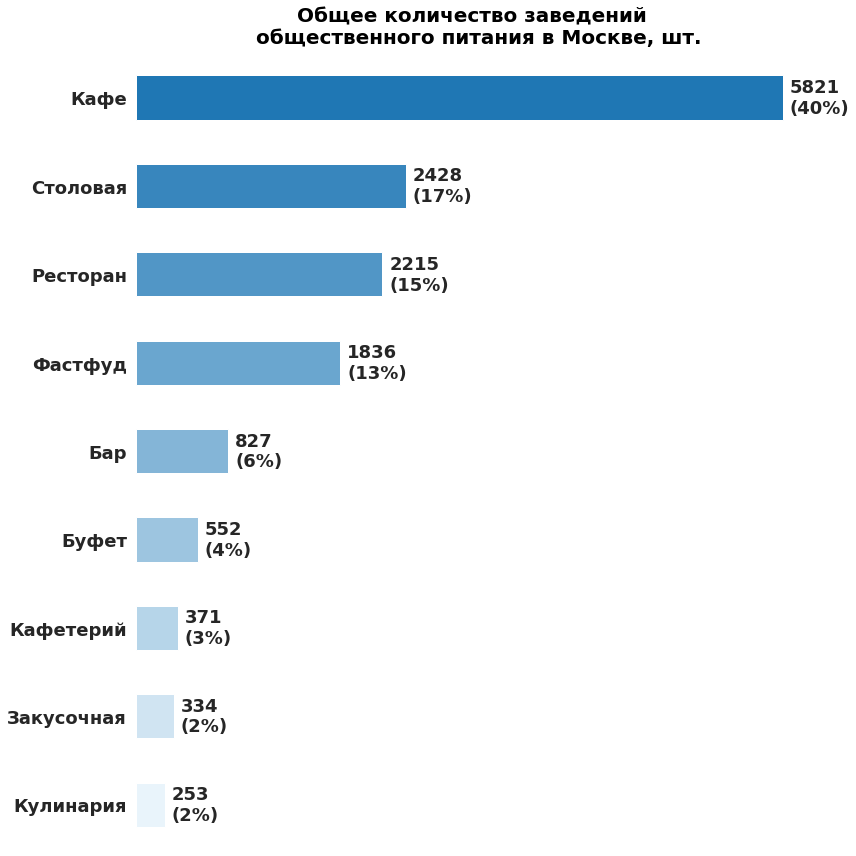

In [125]:
# построение графика общего количества заведений общественного питания в Москве

g = rest_data_pivot.plot.barh(
    y='total',
    #y=rest_data_pivot.index,

    colors = pal_9_rev,
)

plt.gca().invert_yaxis()
plt.title('Общее количество заведений \n общественного питания в Москве, шт.', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)

sns.despine(
    left=True, 
    bottom=True
)

for i, value in enumerate(rest_data_pivot['total']):
    g.text(
        int(value)+(rest_data_pivot['total'].min() / 4),
        i,
        '{:.0f}\n({:.0%})'.format(int(value), value/rest_data_pivot['total'].sum()),
        fontsize=18,
        #ha='center',
        va='center',
        weight='bold'
    )

plt.gca().get_legend().remove()



plt.yticks(weight='bold', fontsize=18)
plt.grid(False)
#g.set_xticks([])
plt.gca().invert_yaxis()
plt.gca().set_xticks([])

plt.tight_layout()
plt.show()

- Явный лидер — кафе для среднего класса с долей в 40%. 
- Далее с 17% идут столовые для рабочих (сегмент ниже кафе) и с 15% рестораны классом выше, чем у кафе.
- Четверку лидеров замыкает фастфуд с 13%.

__В Москве заведения общественного питания в основном ориентируются на средний и дешевый сегмент.__

### Соотношение сетевых и несетевых заведений по количеству

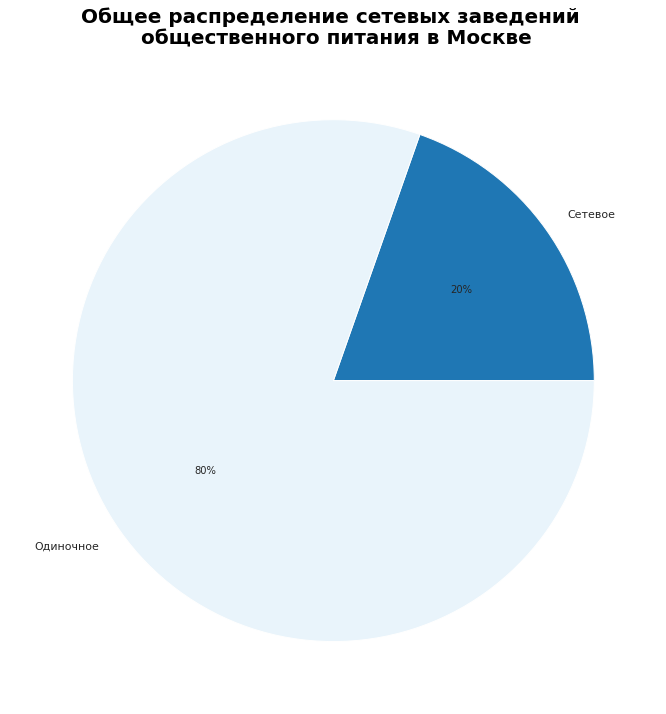

In [126]:
# построение графика общего распределения сетевых заведений общественного питания в Москве

rest_chain_types = rest_data_clean.groupby('chain')['id'].count().sort_values(ascending=True).to_frame()
rest_chain_types.columns = ['chain']

rest_chain_types.plot.pie(
    y='chain', 
    colors = pal_2, 
    autopct='%1.0f%%', 
    counterclock=True,
)

plt.gca().get_legend().remove()
plt.title('Общее распределение сетевых заведений \n общественного питания в Москве', **title_font)
plt.ylabel('', **axis_font)

plt.show()

Общая доля сетевых заведений общественного питания в Москве — 20%.

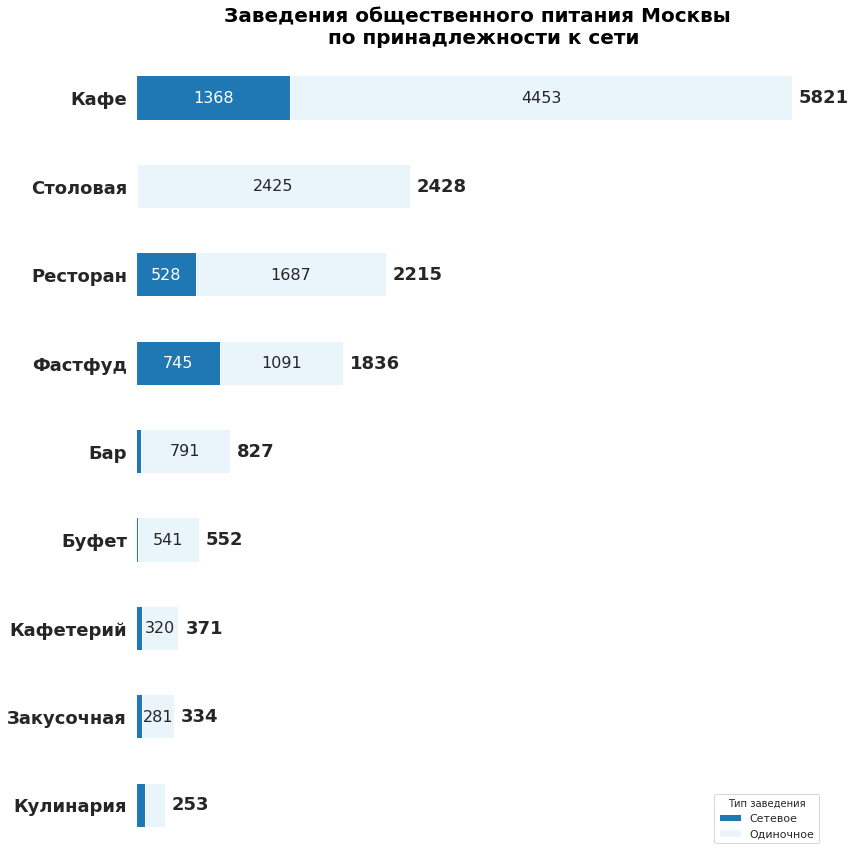

In [127]:
# построение графика заведений общественного питания Москвы по принадлежности к сети

g = rest_data_pivot.plot.barh(
    y=['not_chain', 'chain'],
    stacked=True,
    colors = pal_2,
)

plt.title('Заведения общественного питания Москвы \n по принадлежности к сети', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)

sns.despine(
    left=True, 
    bottom=True
)

for i, value  in enumerate(rest_data_pivot['chain']):
    if value < 250:
        pass
    else:
        g.text(
            value/2 + rest_data_pivot['not_chain'][i],
            i,
            '{:.0f}'.format(value ),
            fontsize=16,
            ha='center',
            va='center',

        )
    
for i, value in enumerate(rest_data_pivot['not_chain']):
    if value < 250:
        pass
    else:
        g.text(
            value/2,
            i,
            '{:.0f}'.format(value ),
            fontsize=16,
            ha='center',
            va='center',
                        color='white'
        )

for i, value in enumerate(rest_data_pivot['total']):
    g.text(
        int(value)+(rest_data_pivot['total'].min() / 4),
        i,
        '{:.0f}'.format(int(value)),
        fontsize=18,
        #ha='center',
        va='center',
        weight='bold'
    )
        
plt.legend(
    ['Сетевое', 'Одиночное'],
    title='Тип заведения',
    loc='lower right',
    #bbox_to_anchor=(0.5, -0.01),
    fancybox=True, 
#    ncol=2
)

plt.yticks(weight='bold', fontsize=18) 
plt.grid(False)
#g.set_xticks([])
plt.gca().set_xticks([])

plt.tight_layout()
plt.show()

- Больше всего сетевых заведений среди кафе — 1,3 тыс. 
- После кафе больше всего сетевых заведений у фастфуда — около 750. Туда входят как знаменитые бургенные, так и уличные киоски с шаурмой без посадочных мест.
- На третьем месте по количеству сетевых заведений — 530 ресторанов. В большинстве, это заведения, открытые по франшизе.

### Объекты общественного питания по сетевому распространению

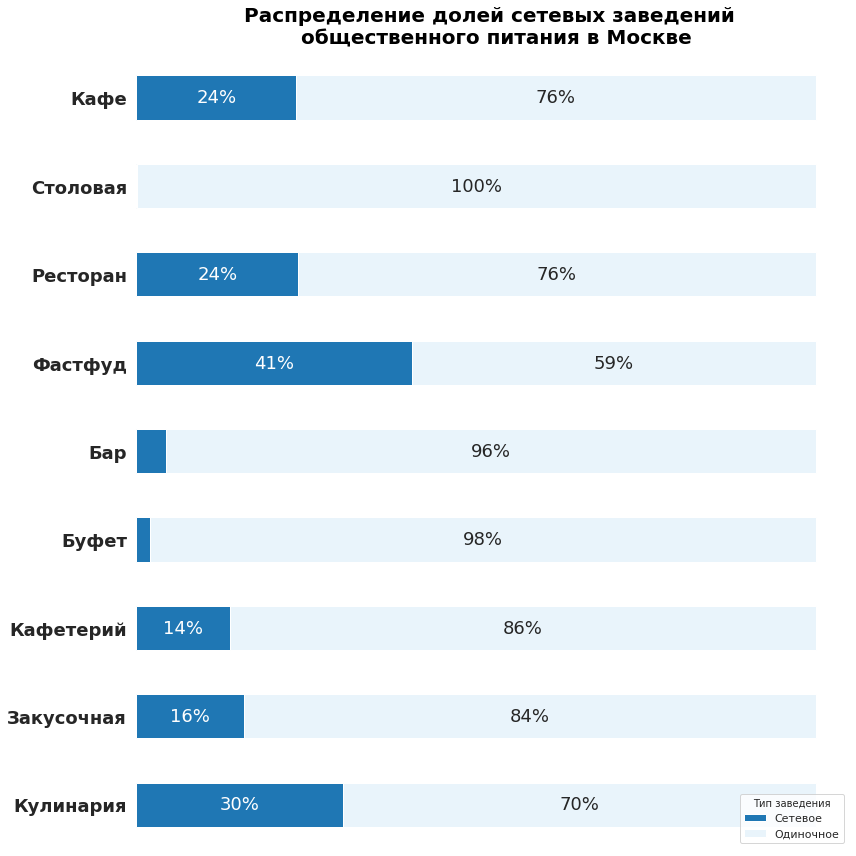

In [128]:
# построение графика распределения долей сетевых заведений общественного питания в Москве

g = rest_data_pivot.plot.barh(
    y=['not_chain_%', 'chain_%'],
    stacked=True,
    colors = pal_2,
)

plt.title('Распределение долей сетевых заведений \n общественного питания в Москве', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)

sns.despine(
    left=True, 
    bottom=True
)

for i, value in enumerate(rest_data_pivot['chain_%']):
    if value < 0.1:
        pass
    else:
        g.text(
            value/2 + (1-value),
            i,
            '{:.0%}'.format(value),
            fontsize=18,
            ha='center',
            va='center',

        )
    
for i, value in enumerate(rest_data_pivot['not_chain_%']):
    if value < 0.1:
        pass
    else:
        g.text(
            value/2,
            i,
            '{:.0%}'.format(value),
            fontsize=18,
            ha='center',
            va='center',
                        color='white'
        )

plt.legend(
    ['Сетевое', 'Одиночное'],
    title='Тип заведения',
    loc='lower right',
    #bbox_to_anchor=(0.5, -0.01),
    fancybox=True, 
    #ncol=2
)
    
plt.grid(False)
plt.yticks(weight='bold', fontsize=18) 
plt.gca().set_xticks([])

plt.tight_layout()
plt.show()

- Наибольшая доля сетевых заведений ожидаемо у фастфуда — 41%.
- На втором месте — кулинария в магазинах с 30%, но в абсолютном значении таких точек в Москве немного.
- Третье место делят с 24% делят кафе и рестораны.

### Посадочные места

#### Среднее количество посадочных мест по типам заведений

In [129]:
# датафрейм медианных значений посадочных мест

median_seat_number = rest_data_clean.groupby(['object_type','chain'])['number'].median().unstack()
median_seat_number.columns = ['chain', 'not_chain']
median_seat_number = median_seat_number.merge(
    rest_data_clean.groupby('object_type')['number'].median().sort_values(ascending=False).to_frame(),
    left_index=True, 
    right_index=True
).sort_values('number', ascending=False)

median_seat_number

,chain,not_chain,number
object_type,,,
Столовая,103,120,103.0
Ресторан,76,90,80.0
Бар,35,44,35.0
Буфет,34,0,32.5
Кафе,30,40,32.0
Кафетерий,5,8,6.0
Фастфуд,0,25,5.0
Закусочная,0,8,0.0
Кулинария,0,3,0.0


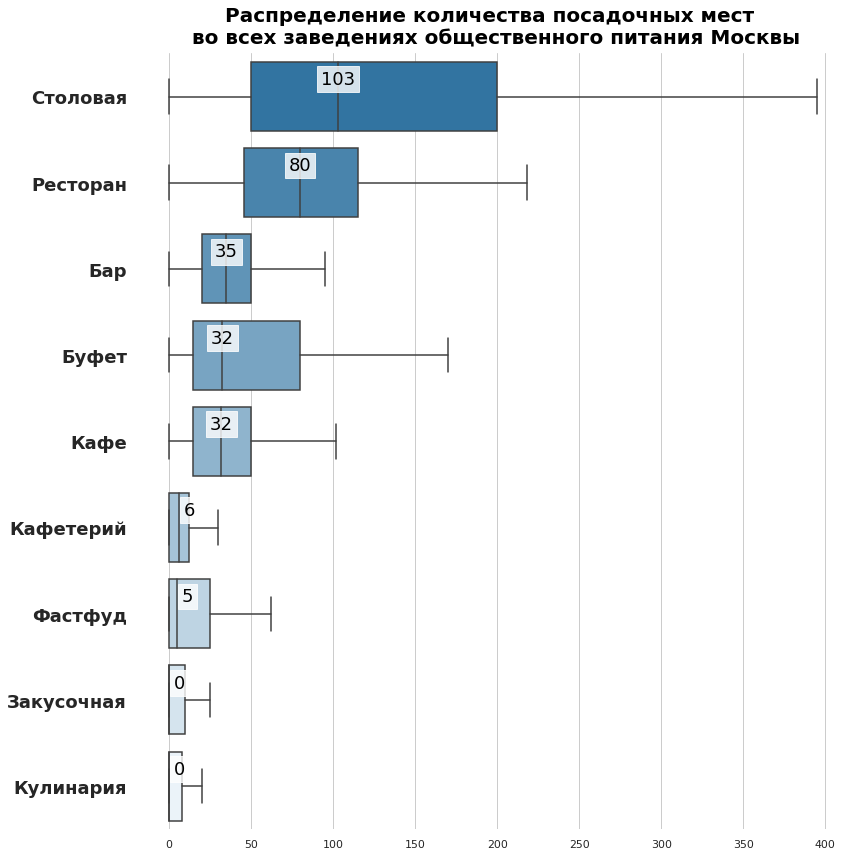

In [130]:
g = sns.boxplot(
    y="object_type",
    x="number", 
    data=rest_data_clean,
    showfliers=False,
    order=median_seat_number.index,
    palette=pal_9
)

plt.title('Распределение количества посадочных мест \n во всех заведениях общественного питания Москвы', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.yticks(weight='bold', fontsize=18) 

try:
    for i, value in enumerate(median_seat_number['number']):
        g.text(
            value + (3 if value < 10 else 0),
            i - 0.2,
            '{:.0f}'.format(value),
            fontsize=18,
            ha=('left' if value < 10 else 'center'),
            va='center',                
            color='black'
            ).set_bbox(dict(
            facecolor='white',
            alpha=0.8,
            #edgecolor='white'
        ))
except:
    pass


sns.despine(
    left=True, 
    bottom=True
)

plt.tight_layout()
plt.show()

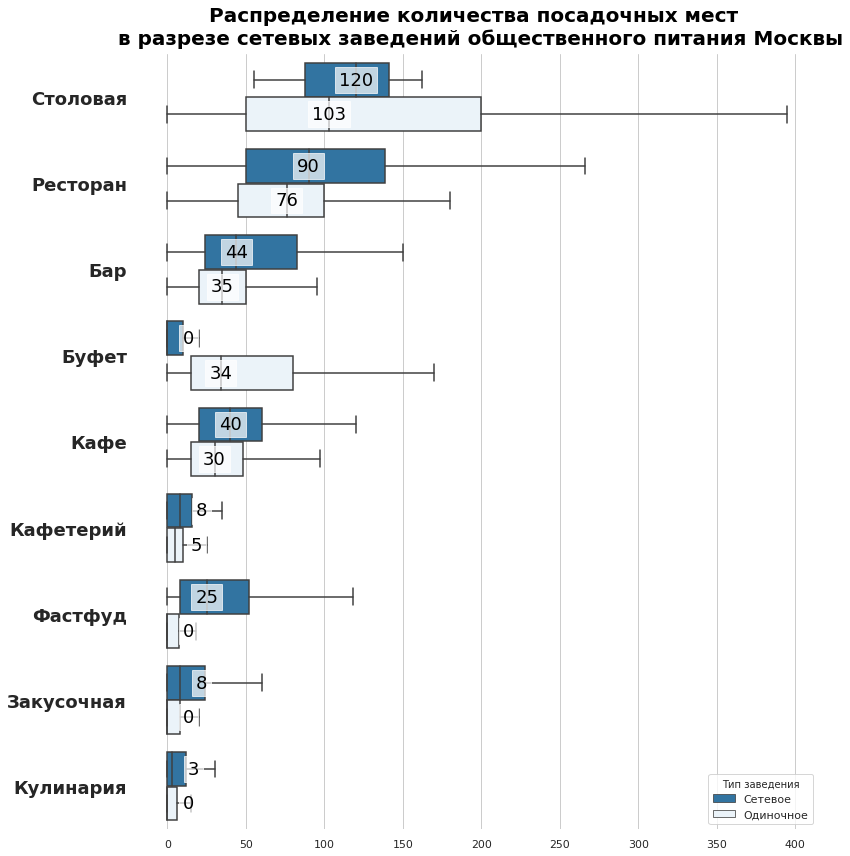

In [131]:
g = sns.boxplot(
    y="object_type",
    x="number", 
    hue="chain",
    data=rest_data_clean,
    showfliers=False,
    palette=pal_2,
    order=median_seat_number.index,
    hue_order=['Сетевое', 'Одиночное']
)

plt.title('Распределение количества посадочных мест \n в разрезе сетевых заведений общественного питания Москвы', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.yticks(weight='bold', fontsize=18) 


try:
    for i, value in enumerate(median_seat_number['not_chain']):
        g.text(
            value + (10 if value < 10 else 0),
            i - 0.2,
            '{:.0f}'.format(value),
            fontsize=18,
            ha=('left' if value < 10 else 'center'),
            va='center',                
            color='black'
            ).set_bbox(dict(
            facecolor='white',
            alpha=0.7,
            #edgecolor='white'
        ))
    for i, value in enumerate(median_seat_number['chain']):
        g.text(
            value + (10 if value < 10 else 0),
            i + 0.2,
            '{:.0f}'.format(value),
            fontsize=18,
            ha=('left' if value < 10 else 'center'),
            va='center',                
            color='black'
            ).set_bbox(dict(
            facecolor='white',
            alpha=0.7,
            #edgecolor='white'
        ))
except:
    pass


plt.legend(
    title='Тип заведения',
    loc='lower right',
    fancybox=True, 
)

sns.despine(
    left=True, 
    bottom=True
)

plt.tight_layout()
plt.show()

- Наибольшее количество посадочных мест и разброс диапазона у столовых — 103-120 шт. При относительно низком среднем чеке, выручка в столовых формируется за счет проходимости большого количества посадочных мест.
- На втором месте по посадочным местам — рестораны с 76-90 шт. В ресторанах средний чек относительно высок, но клиенты сидят долго. Это компенсируется большим залом.
- Бары, буфеты и кафе на одном уровне по посадочным местам — около 30-40 шт. Для этих заведений характерна одна площадь зала и проходимость. 
- __Количество посадочных мест балансирует проходимость и средний чек заведения.__

#### Зависимость посадочных мест от количества заведений в сети

In [132]:
# расчет количества заведений в сети и медиана количества посадочных мест
chain_number = rest_data_clean.query('chain == "Сетевое"').pivot_table(
    index='object_name',
    values='number',
    aggfunc={'object_name' : 'count', 'number' : 'median'}

)
chain_number.columns = ['median_seats','rest_in_chain']

In [133]:
chain_number['rest_in_chain'].mean()

4.045070422535211

In [134]:
chain_number.sort_values('rest_in_chain', ascending=False).head(15)

,median_seats,rest_in_chain
object_name,,
KFC,45.0,147
Шоколадница,50.0,139
Бургер Кинг,42.0,117
Макдоналдс,75.5,116
Домино'с Пицца,16.0,86
Теремок,20.0,83
Крошка Картошка,15.0,77
Милти,0.0,62
Суши Wok,6.0,60


In [135]:
chain_number['median_seats'].mean()

59.23943661971831

In [136]:
chain_number.sort_values('median_seats', ascending=False).head(15)

,median_seats,rest_in_chain
object_name,,
Темпл Бар,356.0,1
БАКИНСКИЙ БУЛЬВАР,350.0,1
Чешская пивная «Козловица»,306.0,1
Ян Примус,300.0,1
Кафе МУ-МУ,300.0,1
Якитория и Ян Примус,282.0,1
Старина Миллер,280.0,1
Пражечка,266.0,1
Молли гвинз,250.0,1


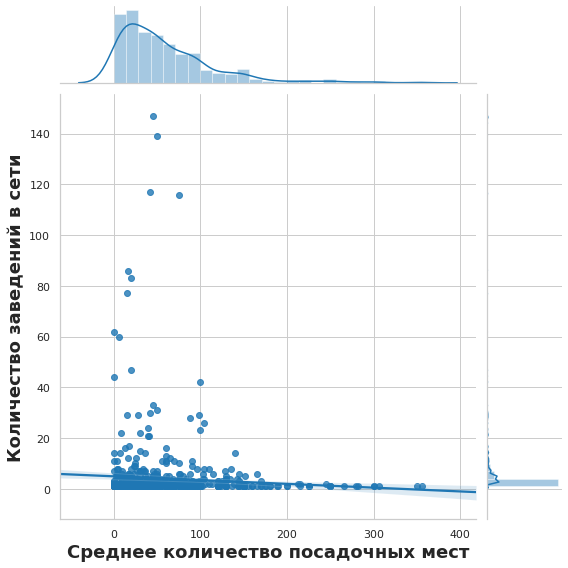

In [137]:
sns.jointplot(
    x="median_seats", 
    y="rest_in_chain", 
    data=chain_number,
    kind='reg',
    height=8,
    color="tab:blue",
)

#plt.title('Зависимость количества посадочных мест \n от количества заведений в сети', **title_font)
plt.xlabel('Среднее количество посадочных мест', **axis_font)
plt.ylabel('Количество заведений в сети', **axis_font)

plt.tight_layout()
plt.show()

- Для Москвы характерно около 4 заведений в сети с количеством посадочных мест до 60.
- Выбросы по количеству ресторанов— это мировые сети, например, KFC, Бургер Кинг, Макдоналдс.
- Выбросы по количеству посадочных мест— это крупные многоэтажные заведения, Темпл Бар, Бакинский Бульвар, Му-му и т.д.

### Распределение объектов общественного питания по улицам

#### Топ-10 улиц по количеству объектов общественного питания

In [138]:
# свод датафрейма топ-10 улиц по количеству объектов общественного питания
top_10_streets = rest_data_clean.groupby('street_manual')\
    .agg({'street_manual' : 'count', 'district' : 'first'})

top_10_streets.columns = ['count','district']
top_10_streets = top_10_streets.sort_values('count', ascending=False).head(10).reset_index()
top_10_streets.columns = ['street','count','district']
top_10_streets

,street,count,district
0,проспект Мира,204,Алексеевский район
1,Профсоюзная улица,183,Академический район
2,Ленинградский проспект,173,район Аэропорт
3,Пресненская набережная,167,Пресненский район
4,Варшавское шоссе,163,район Северное
5,Ленинский проспект,148,Гагаринский район
6,проспект Вернадского,132,Гагаринский район
7,Кутузовский проспект,114,район Дорогомилово
8,Каширское шоссе,112,район Москворечье-Сабурово
9,Кировоградская улица,110,район Чертаново


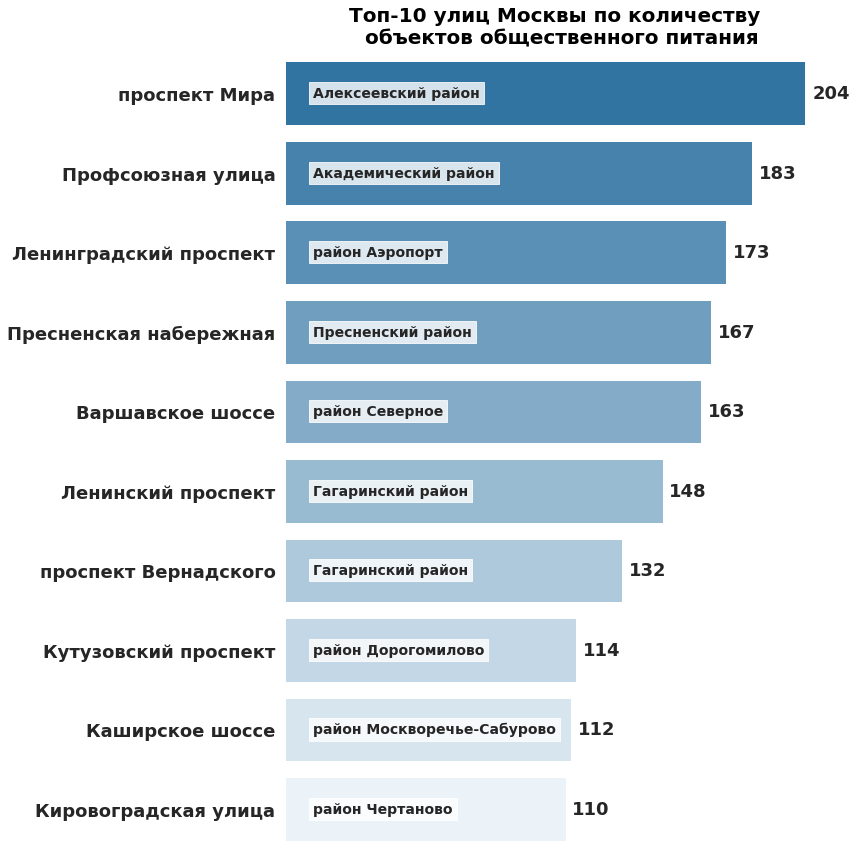

In [139]:
# график топ-10 улиц Москвы по количеству объектов общественного питания
g1 = sns.barplot(
    x="count",
    y='street',
    data=top_10_streets,
    palette=pal_10
)

plt.title('Топ-10 улиц Москвы по количеству \n объектов общественного питания', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.yticks(
    weight='bold',
    fontsize=18
)

sns.despine(
    left=True, 
    bottom=True
)

# надписи количества заведений
for i, value in enumerate(top_10_streets['count']):
    g1.text(
        top_10_streets['count'].min() * 0.1,
        i,
        '{}'.format(top_10_streets['district'][i]),
        fontsize=14,
        ha='left',
        va='center',
        weight='bold'
    ).set_bbox(dict(
            facecolor='white',
            alpha=0.8,
            #edgecolor='white'
        ))
    g1.text(
        value + 10,
        i,
        '{:.0f}'.format(int(value)),
        fontsize=18,
        ha='center',
        va='center',
        weight='bold'
    ).set_bbox(dict(
            facecolor='white',
            alpha=0.8,
            #edgecolor='white'
        ))
    
    
plt.grid(False)
plt.gca().set_xticks([])
plt.tight_layout()
plt.show()

Улицы с наибольшим количеством заведений расположены:
- на длинных и широких шоссе,
- вне исторического центра Москвы.

#### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

In [140]:
# список топ-10 улиц по количеству заведений
top_10_streets_list = top_10_streets["street"].values.tolist()

# выборка датафрейма для топ-10 улиц по количеству заведений
rest_data_top_10_streets = rest_data_clean.query('street_manual in @top_10_streets_list')

In [141]:
# упорядочивание по медианте распределения количества посадочных мест на топ-10 улиц 
number_median_top_10_streets = rest_data_top_10_streets.groupby('street_manual')['number'].median(). \
sort_values(ascending=False).to_frame().reset_index()

number_median_top_10_streets.columns = ['street', 'number_median']

number_median_top_10_streets

,street,number_median
0,проспект Мира,46.5
1,Ленинский проспект,45.0
2,проспект Вернадского,40.0
3,Ленинградский проспект,40.0
4,Кутузовский проспект,40.0
5,Пресненская набережная,30.0
6,Кировоградская улица,30.0
7,Варшавское шоссе,30.0
8,Каширское шоссе,25.0
9,Профсоюзная улица,24.0


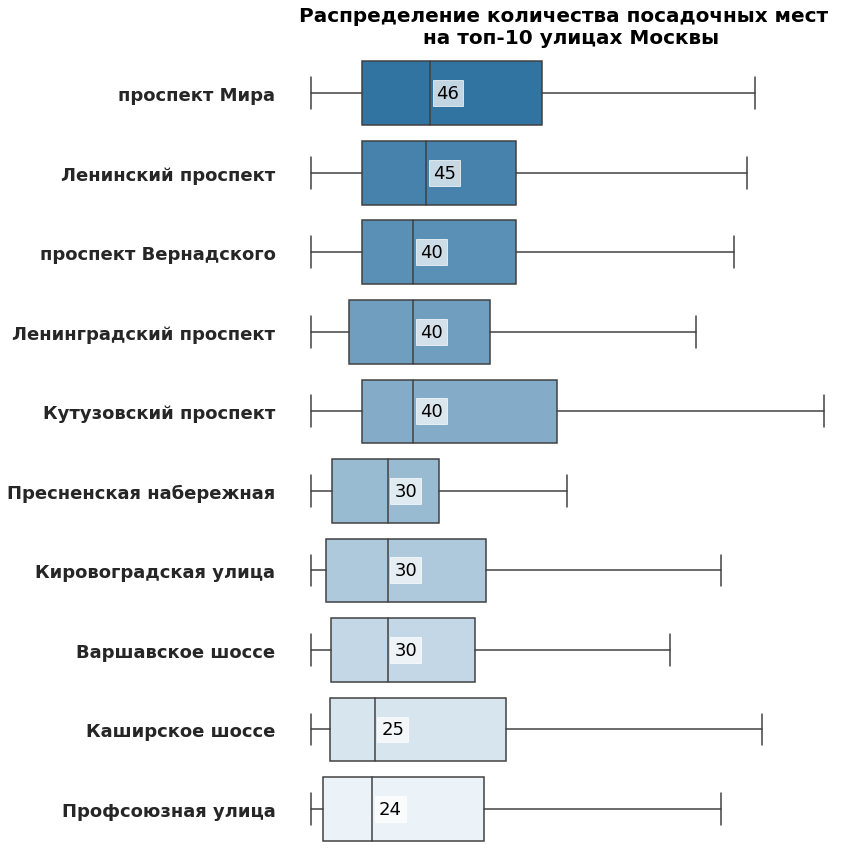

In [142]:
g = sns.boxplot(
    y="street_manual",
    x="number", 
    data=rest_data_top_10_streets,
    showfliers=False,
    order=number_median_top_10_streets.street,
    palette=pal_10
)

plt.title('Распределение количества посадочных мест \n на топ-10 улицах Москвы', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.yticks(
    weight='bold',
    fontsize=18
)

for i, value in enumerate(number_median_top_10_streets['number_median']):
    g.text(
        value + 7,
        i,
        '{:.0f}'.format(value),
        fontsize=18,
        ha=('left' if value < 10 else 'center'),
        va='center',                
        color='black'
        ).set_bbox(dict(
        facecolor='white',
        alpha=0.7,
        #edgecolor='white'
))

sns.despine(
    left=True, 
    bottom=True
)
  
plt.grid(False)
plt.gca().set_xticks([])

plt.tight_layout()
plt.show()

- На проходимых улицах общепит максимизирует выручку за счет увеличения количества посадочных мест в зале.
- Чем длиннее улица, тем больше разнопланово общепита на ней расположено и больший разброс количества посадочных мест.
- На Пресненской набережной меньший разброс из-за близости Москва-Сити и преобладания более дорогих нишевых заведений.

#### Улицы с одним объектом общественного питания

In [143]:
# группировка датафрейма по улицам
streets_one_rest = rest_data_clean.groupby('street_manual')\
    .agg({'street_manual' : 'count', 'district' : 'first'})
streets_one_rest.columns = ['count','district']

# выборка улиц с одним общепитом
streets_one_rest = streets_one_rest.query('count == 1')

print('Число улиц с одним объектом общественного питания: {}'.format(len(streets_one_rest)))

Число улиц с одним объектом общественного питания: 541


In [144]:
# группировка датафрейма улиц по районам
district_with_weak_streats = streets_one_rest.groupby('district').sum().sort_values('count', ascending=False).head(10)
district_with_weak_streats

,count
district,
Басманный район,25
Таганский район,25
район Хамовники,22
Тверской район,19
район Арбат,18
район Марьина Роща,16
Пресненский район,16
район Сокольники,15
район Замоскворечье,12


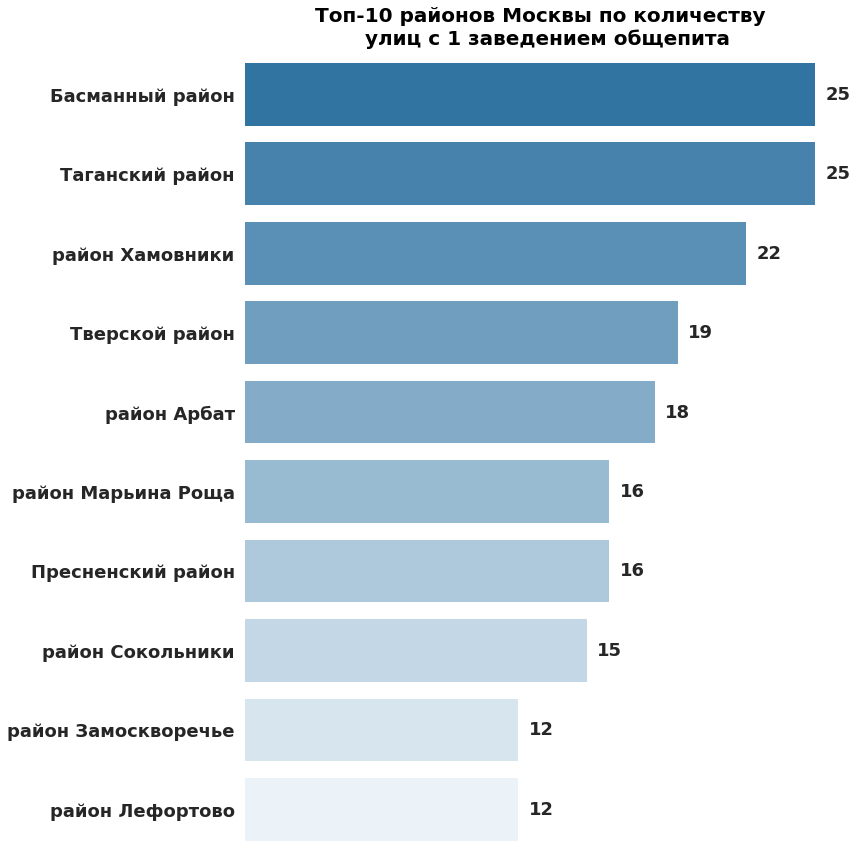

In [145]:
# график топ-10 улиц Москвы по количеству объектов общественного питания
g1 = sns.barplot(
    y=district_with_weak_streats.index,
    x='count',
    data=district_with_weak_streats,
    order=district_with_weak_streats.index,
    palette=pal_10
)

plt.title('Топ-10 районов Москвы по количеству \n улиц с 1 заведением общепита', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.yticks(
    weight='bold',
    fontsize=18
)

sns.despine(
    left=True, 
    bottom=True
)

# надписи количества заведений
for i, value in enumerate(district_with_weak_streats['count']):
    g1.text(
        value + 1,
        i,
        '{:.0f}'.format(value),
        fontsize=18,
        ha='center',
        va='center',
        weight='bold'
    ).set_bbox(dict(
            facecolor='white',
            alpha=0.8,
            #edgecolor='white'
        ))
plt.grid(False)
plt.gca().set_xticks([])
plt.tight_layout()
plt.show()

- В Басманном и Таганском районах больше всего улиц с одним заведением общепита.
- Улицы с одним заведением общепита чаще всего расположены в спальных районах.
- Центральный районы, например, Арбат и Таганка, попали в выборку из-за большого количества коротких улиц.

## Вывод
<a id = "conclusion"></a>

- __Общий вывод:__
    - В Москве заведения общественного питания в основном ориентируются на средний класс. Основа рынка общепита — кафе с долей около 40% от общего количества заведений.
    - Количество посадочных мест сильно зависти от проходимости и ценового сегмета заведния. При низком среднем чеке выручка формируется за счет проходимости и большого количества посадочных мест, а при дорогом чеке клиенты сидят долго в заведении и это компенсируется большим залом.
    - Улицы с наибольшим количеством заведений расположены на длинных и широких шоссе вне исторического центра Москвы.
    - На проходимых улицах общепит максимизирует выручку за счет увеличения количества посадочных мест в зале.
- __Рекомендации:__
    - Открывать заведение лучше в формате кафе — от общего количества общепита их около 40%. Менее предпочтительны форматы ресторана (15%) или фастфуда (13%). 
    - Заведение с роботами предполагает серьезные кап. вложения, соизмеримые с форматом ресторана. В таком случае целесообразно рассмотреть кафе с количеством посадочных мест должно быть в диапазоне от 40 до 75 шт. ближе к верхней границе.
    - Несмотря на серьезные кап. вложения, заведение планируется открывать в формате кафе. Это выделяет проект из общего распределение и делает его нишевым. В таком случае целесообразно рассмотеть открытие в районах туристического центра: Арбат, Пресненская набережная, где клиенты готовы платить большие деньги, чем в среднем по типу заведения.
    - Развитие в районах с малой конкуренцией нецелесообразно, так как это спальные районы.
- __Возможность развития сети:__
    - Общая доля сетевых заведений общественного питания в Москве — 20%.
    - Больше всего сетевых заведений среди кафе 1300 и фастфуда 750. В основном это крупные, знаменитые, старые бургенные и уличные киоски с шаурмой и франшизные кофейни без посадочных мест.

## Презентация
<a id = "presentation"></a>

<a href="https://yadi.sk/i/s5kgM1zgXHD2ZA">
Ссылка на презентацию в PDF
</a>